In [114]:
import math as m
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from random import random

from scipy.stats import kde
from mpl_toolkits import mplot3d
from scipy.interpolate import interp1d

from scipy.spatial import distance

In [2]:
DISTANCE = 1100 #pc
RADIUS_TIDAL = 10.25 #pc
RADIUS_CENTRE = 2.98 #pc
K = 27.27

POPULATION = 1300 
POPULATION_BACKGROUND = 15000

In [3]:
size = (2 * RADIUS_TIDAL / DISTANCE * 206264.8 / 3600) ** 2
print(f'cluster size is {size} square degrees')

cluster size is 1.1401646983679317 square degrees


In [120]:
def radial_distribution():
    r = np.linspace(0, RADIUS, 100)
    

def neumann(data_1, data_2):
    """get r randomly from radial distribution (data_2)"""
    iter = True
    while iter == True:
        x, yr = random() * data_1.max(), random() * data_2.max()
        y = interp1d(data_1, data_2)
        if x >= data_1.min() and yr <= y(x):
            iter = False
            return x
        else:
            iter = True
            
def make_cluster():
    angles_array = np.random.random_sample((POPULATION,)) * 2 * np.pi
    distance_array = kings_profile()
     
    cluster = pd.DataFrame(data={'angle': angles_array, 
                                 'distance': distance_array})
    
    cluster['x'] = cluster['distance'] * np.cos(cluster['angle'])
    cluster['y'] = cluster['distance'] * np.sin(cluster['angle'])
    
    return cluster.loc[:,'x':'y']

def make_background():
    
    number = int(POPULATION_BACKGROUND * 4 / np.pi)
    background = pd.DataFrame()
    
    list_choice = [1] * (number // 2) + [-1] * (number - number // 2)
    
    background['x'] = np.random.random_sample((number,)) * RADIUS_TIDAL * np.random.choice(list_choice, number)
    background['y'] = np.random.random_sample((number,)) * RADIUS_TIDAL * np.random.choice(list_choice, number)
    
    mask = (background['x'] ** 2 + background['y'] ** 2) < RADIUS_TIDAL ** 2
    
    return background[mask]

In [121]:
def kings_profile():
    r_sample = np.linspace(0, RADIUS_TIDAL+0.1, 1000)
    r = np.ndarray(POPULATION)
    
    func_king = K * (1 / (np.sqrt(1 + (r_sample / RADIUS_CENTRE) ** 2)) -
                     1 / (np.sqrt(1 + (RADIUS_TIDAL / RADIUS_CENTRE) ** 2)) 
                     ) ** 2
    for i in range(0, POPULATION):
        r[i] = neumann(r_sample, func_king)
    return r

In [137]:
cluster = pd.concat((make_cluster(), make_background()))

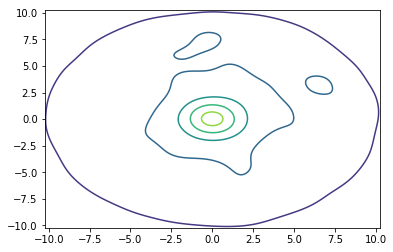

In [146]:
# create data
x = cluster['x']
y = cluster['y']
 
# Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
nbins=300
k = kde.gaussian_kde([x,y])
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
f = zi.reshape(xi.shape)

# Make the plot
plt.contour(xi, yi, f)
plt.show()

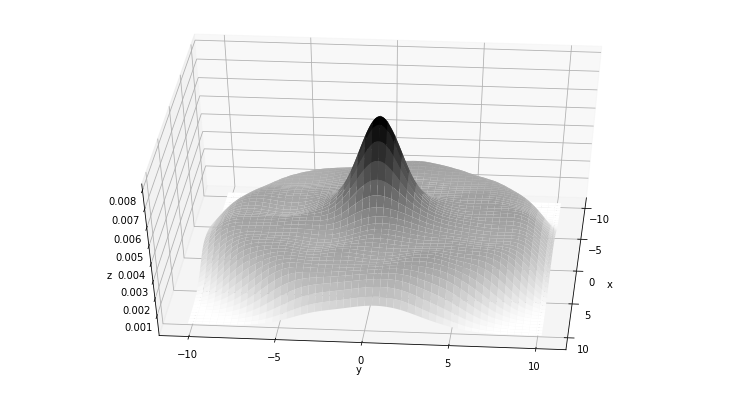

In [140]:
fig = plt.figure(figsize=(13, 7))
ax = plt.axes(projection='3d')
ax.plot_surface(xi, yi, zi.reshape(xi.shape), cmap='binary')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(45, 5)

In [141]:
distances = distance.pdist(cluster[['x','y']], 'euclidean')

In [142]:
angular_distances = distances / DISTANCE * 206264.8

n_distances = POPULATION * (POPULATION_BACKGROUND + POPULATION) - (POPULATION + 1) * POPULATION // 2 
angular_distances_only_cluster = angular_distances[0 : n_distances]

In [143]:
mask = (angular_distances_only_cluster < 2)
unresolved_number = len(angular_distances_only_cluster[mask])
unresolved_number

68

In [144]:
unresolved_number / POPULATION

0.052307692307692305